/home/ivan/Documentos/Github/zennit-crp/.conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ivan/Documentos/Github/zennit-crp/.conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Swin_B_Weights.IMAGENET1K_V1`. You can also use `weights=Swin_B_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


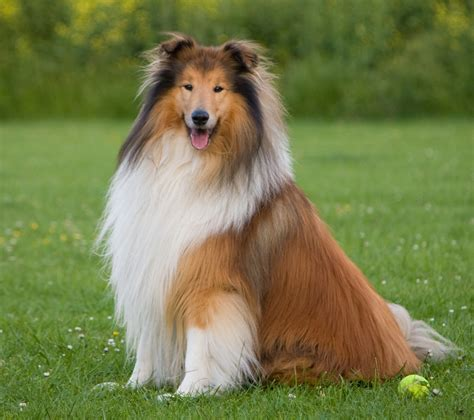

In [ ]:
from captum.attr import Lime, LimeBase
from captum._utils.models.linear_model import SkLearnLasso
from torchvision.models.swin_transformer import swin_b
from torchvision.models.resnet import resnet50
from zennit.canonizers import SequentialMergeBatchNorm
from zennit.composites import EpsilonPlusFlat
from crp.helper import get_layer_names
from crp.attribution import CondAttribution
import numpy as np
import torch
from PIL import Image
import torchvision.transforms as T
import seaborn as sns
from matplotlib import pyplot as plt

device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = swin_b(pretrained=True).to(device)
model.eval()
layer_names = get_layer_names(
    model, types=[torch.nn.Conv2d, torch.nn.Linear, torch.nn.AdaptiveAvgPool2d]
)

pre_last_layer_name = layer_names[-2]

# Añade una función a model para obtener la salida de la penúltima capa
def get_pre_last_layer_output(x):
    for name, layer in model.named_children():
        x = layer(x)
        if name == pre_last_layer_name:
            return x
model.get_pre_last_layer_output = get_pre_last_layer_output
image = Image.open("images/dog.jpeg")
transform = T.Compose(
    [
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
sample = transform(image).unsqueeze(0).to(device)


sample.requires_grad_(True)

segmentation_mask = torch.zeros((sample.shape[-2], sample.shape[-1]), dtype=torch.int64)
n_parts = 10
for i in range(n_parts):
    i_step = sample.shape[-2] // n_parts
    for j in range(n_parts):
        j_step = sample.shape[-1] // n_parts
        segmentation_mask[
            i * i_step : (i + 1) * i_step, j * j_step : (j + 1) * j_step
        ] = (i * n_parts + j)

image

In [47]:
feat_to_explain = 352
sigma = 13
def forward_feats(input):
    """
    Forward pass through the model to get the features.
    """
    with torch.no_grad():
        feats = model.get_pre_last_layer_output(input)

    feats = feats.view(feats.size(0), -1)  # Remove spatial dimensions
    feats = feats.cpu().detach().numpy()
    # Sum the features across the batch dimension
    return feats[:, feat_to_explain]
    #return np.sum(feats, axis=0)

def perturb_func(input, **kwargs):
    segmentation_mask = kwargs.get("feature_mask")
    num_interp_features = segmentation_mask.max().item() + 1

    binary_vector = torch.zeros(
        (input.shape[0], num_interp_features), dtype=torch.int64, device=input.device
    )

    
    # Generate input.shape[0] random values from an exponential distribution
    value = np.random.exponential(scale=sigma, size=input.shape[0])
    value = np.clip(value, 1, num_interp_features - 1).astype(int)

    # select value indices from the binary vector and change them to 1
    for i in range(input.shape[0]):
        indices = torch.randperm(num_interp_features)[:value[i]]
        binary_vector[i, indices] = 1

    return binary_vector


def sim_func(original_input, perturbed_input, perturbed_interpretable_input, **kwargs):
    distance = (
        len(perturbed_interpretable_input)
        - torch.sum(perturbed_interpretable_input).item()
    )
    distance = torch.exp(torch.tensor(-distance / sigma / sigma))
    return distance.item()


def from_interp_rep_transform(curr_sample, original_input, **kwargs):

    segmentation_mask = kwargs.get("feature_mask")
    num_interp_features = segmentation_mask.max().item() + 1

    mask = torch.zeros_like(segmentation_mask, dtype=torch.float32) + 1

    for i in range(num_interp_features):
        if curr_sample[0, i] == 1:
            segment_indices = segmentation_mask == i
            mask[segment_indices] = 0

    mask = mask.unsqueeze(0).unsqueeze(1)

    transformed_input = original_input * mask

    return transformed_input

In [48]:
lime_atributor = LimeBase(
    forward_func=forward_feats,
    similarity_func=sim_func,
    interpretable_model=SkLearnLasso(alpha=0.01),
    from_interp_rep_transform=from_interp_rep_transform,
    perturb_func=perturb_func,
    perturb_interpretable_space=True,
    to_interp_rep_transform=None,
)

attribution = lime_atributor.attribute(
    sample,
    feature_mask=segmentation_mask,
    n_samples=1000,
    show_progress=True,
    return_interpretable_representation=True,
)

Lime Base attribution: 100%|██████████| 1000/1000 [14:00<00:00,  1.19it/s]


/tmp/ipykernel_63127/256117155.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  heatmap = T.Resize(image.size[::-1])(torch.tensor(heatmap).unsqueeze(0).unsqueeze(0)).squeeze().numpy()


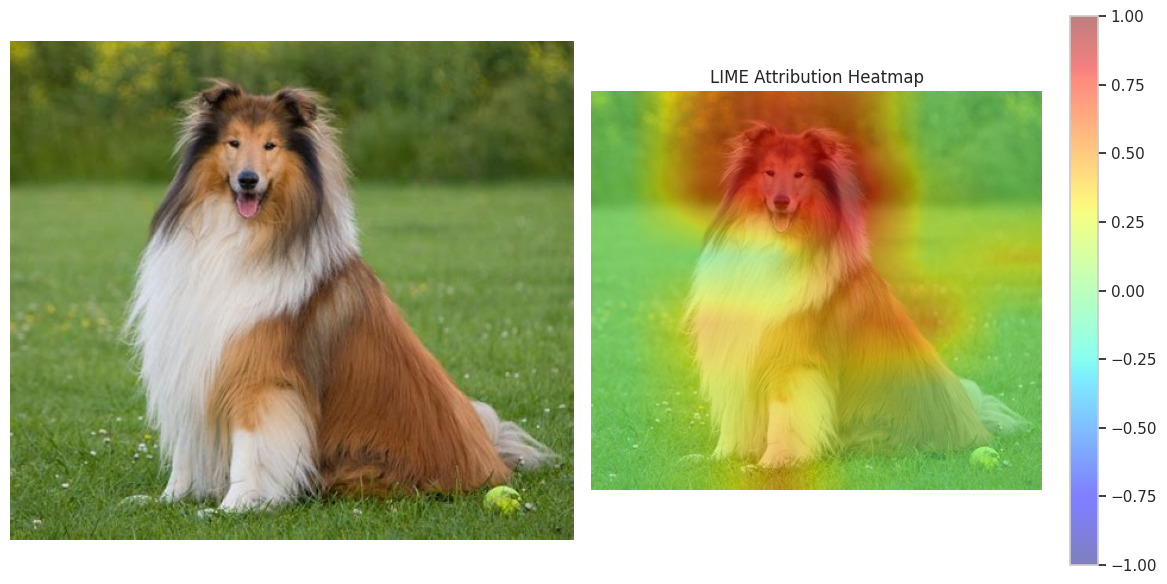

In [ ]:
import os
if not os.path.exists("feats"):
    os.makedirs("feats")
for feat in [471, 352,898,50,943]:
    feat_to_explain = feat
    lime_atributor = LimeBase(
        forward_func=forward_feats,
        similarity_func=sim_func,
        interpretable_model=SkLearnLasso(alpha=0.01),
        from_interp_rep_transform=from_interp_rep_transform,
        perturb_func=perturb_func,
        perturb_interpretable_space=True,
        to_interp_rep_transform=None,
    )

    attribution = lime_atributor.attribute(
        sample,
        feature_mask=segmentation_mask,
        n_samples=1000,
        show_progress=True,
        return_interpretable_representation=True,
    )

    heatmap = attribution.reshape((n_parts, n_parts))
    # Show the original image and, on its right, the attribution heatmap with the original image on the background
    vmax = heatmap.abs().max().item()
    vmin = -vmax
    heatmap = heatmap/ vmax 
    # Resize the heatmap to match the original image size
    heatmap = T.Resize(image.size[::-1])(torch.tensor(heatmap).unsqueeze(0).unsqueeze(0)).squeeze().numpy()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.imshow(heatmap, alpha=0.5, cmap="jet",vmax=1, vmin=-1)
    plt.axis("off")
    plt.colorbar()
    plt.tight_layout()
    plt.title("LIME Attribution Heatmap Feat {}".format(feat_to_explain))
    sns.set_style("whitegrid")
    # Save the figure
    plt.savefig(f"feats/lime_attribution_heatmap_feat_{feat_to_explain}.png")